In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import gridspec
import imblearn
from imblearn.under_sampling import RandomUnderSampler
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split 
from statsmodels.stats.outliers_influence import variance_inflation_factor
#from pandas_profiling import ProfileReport
from sklearn import tree
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.neural_network import MLPClassifier 


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [123]:
train = pd.read_csv('ads_train.csv')

In [ ]:
train.info()

In [125]:
train.drop('Unnamed: 0', axis = 1, inplace = True)

KeyError: ignored

In [126]:
#Replace NA with 0 in Buy_Freq:
train.buy_freq.fillna(0, inplace=True)
train.isnull().sum()

isbuyer                0
buy_freq               0
visit_freq             0
buy_interval           0
sv_interval            0
expected_time_buy      0
expected_time_visit    0
last_buy               0
last_visit             0
multiple_buy           0
multiple_visit         0
uniq_urls              0
num_checkins           0
y_buy                  0
dtype: int64

In [ ]:
train.describe().transpose()[['min','max','mean']]

,min,max,mean
isbuyer,0.0000,1.00000,0.042398
buy_freq,0.0000,15.00000,0.052553
visit_freq,0.0000,84.00000,1.868199
buy_interval,0.0000,174.62500,0.197411
sv_interval,0.0000,184.91670,5.862179
expected_time_buy,-181.9238,84.28571,-0.174376
expected_time_visit,-187.6156,91.40192,-10.136685
last_buy,0.0000,188.00000,64.657384
last_visit,0.0000,188.00000,64.657384
multiple_buy,0.0000,1.00000,0.005967


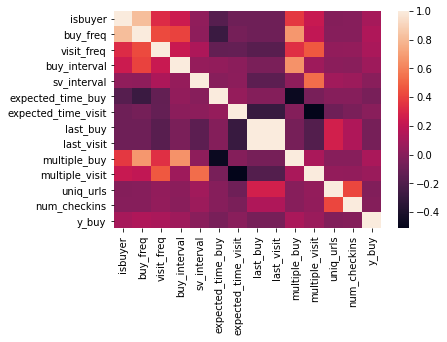

In [ ]:
corrMatrix = train.corr()
sns.heatmap(corrMatrix, annot=False)
plt.show()

In [ ]:
## spot the highly correlated variables with threshold = 0.9
columns = np.full((corrMatrix.shape[0],), True, dtype=bool)
for i in range(corrMatrix.shape[0]):
    for j in range(i+1, corrMatrix.shape[0]):
        if corrMatrix.iloc[i,j] >= 0.9:
            if columns[j]:
                columns[j] = False
selected_columns = train.columns[columns]

print(len(selected_columns))
print(selected_columns) # turn out, the removed variable is last_visit




13
Index(['isbuyer', 'buy_freq', 'visit_freq', 'buy_interval', 'sv_interval',
       'expected_time_buy', 'expected_time_visit', 'last_buy', 'multiple_buy',
       'multiple_visit', 'uniq_urls', 'num_checkins', 'y_buy'],
      dtype='object')


In [ ]:
## Remove last_visit and keep last_buy:
train = train[selected_columns]
train.shape


(38209, 13)

Because the y_buy is a categorical value, I will chose Logistic Regression. There are many benefits of using Logistic Regression over Linear Regression or Multi Linear Regression, especially in this case

In [ ]:
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC 
from sklearn.neural_network import MLPClassifier 
from scipy import stats
from sklearn.impute import KNNImputer
import statsmodels.api as sm
from sklearn import tree
#import graphviz

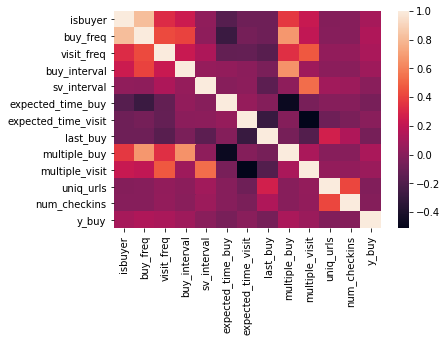

In [ ]:
sns.heatmap((train.corr()), annot = False)

0    38037
1      172
Name: y_buy, dtype: int64


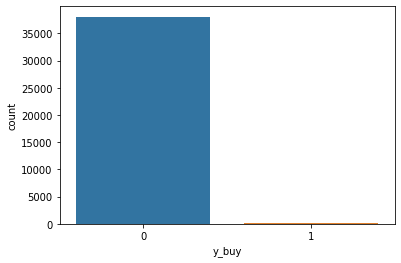

In [ ]:
sns.countplot(x = 'y_buy', data =train)
print(train['y_buy'].value_counts())

In [ ]:
train

,isbuyer,buy_freq,visit_freq,buy_interval,sv_interval,expected_time_buy,expected_time_visit,last_buy,multiple_buy,multiple_visit,uniq_urls,num_checkins,y_buy
0,0,0.0,1,0.0,0.000000,0.0,0.000000,106,0,0,169,2130,0
1,0,0.0,1,0.0,0.000000,0.0,0.000000,6,0,0,150,539,0
2,0,0.0,2,0.0,0.500000,0.0,-101.149300,101,0,1,103,362,0
3,0,0.0,1,0.0,0.000000,0.0,0.000000,42,0,0,17,35,0
4,0,0.0,3,0.0,45.479170,0.0,-34.144730,64,0,1,100,298,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
38204,0,0.0,3,0.0,30.979170,0.0,12.621240,8,0,1,168,2080,0
38205,0,0.0,2,0.0,1.041667,0.0,-0.916713,1,0,1,1,15,0
38206,0,0.0,1,0.0,0.000000,0.0,0.000000,20,0,0,132,556,0
38207,0,0.0,1,0.0,0.000000,0.0,0.000000,180,0,0,71,400,0


In [127]:
undersample = RandomUnderSampler(sampling_strategy=0.5) 

In [128]:
cols = train.columns.tolist()
cols = [c for c in cols if c not in ["y_buy"]]
target = "y_buy"
#cols

In [129]:
#define X and Y
X = train[cols]
Y = train[target]

#undersample
X_under, Y_under = undersample.fit_resample(X, Y)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [130]:
print(X_under.shape)
print(Y_under.shape)


(516, 13)
(516,)


In [131]:
Y_under = pd.DataFrame(Y_under, columns = ['y_buy'])
Y_under.shape
Y_under


,y_buy
0,0
1,0
2,0
3,0
4,0
...,...
511,1
512,1
513,1
514,1


In [132]:
X_under = pd.DataFrame(X_under, columns =[cols])
X_under.shape
X_under

,isbuyer,buy_freq,visit_freq,buy_interval,sv_interval,expected_time_buy,expected_time_visit,last_buy,last_visit,multiple_buy,multiple_visit,uniq_urls,num_checkins
0,0.0,0.0,2.0,0.0,33.041670,0.0,-45.541640,62.0,62.0,0.0,1.0,171.0,3437.0
1,0.0,0.0,1.0,0.0,0.000000,0.0,0.000000,26.0,26.0,0.0,0.0,61.0,140.0
2,0.0,0.0,2.0,0.0,7.125000,0.0,-60.947240,64.0,64.0,0.0,1.0,108.0,595.0
3,0.0,0.0,5.0,0.0,3.489583,0.0,-132.346300,135.0,135.0,0.0,1.0,190.0,616.0
4,0.0,0.0,1.0,0.0,0.000000,0.0,0.000000,81.0,81.0,0.0,0.0,25.0,125.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
511,0.0,0.0,3.0,0.0,3.687500,0.0,1.666954,0.0,0.0,0.0,1.0,15.0,45.0
512,0.0,0.0,1.0,0.0,0.000000,0.0,0.000000,2.0,2.0,0.0,0.0,55.0,85.0
513,0.0,0.0,3.0,0.0,4.500000,0.0,2.963158,0.0,0.0,0.0,1.0,1.0,45.0
514,0.0,0.0,1.0,0.0,0.000000,0.0,0.000000,1.0,1.0,0.0,0.0,21.0,76.0


In [133]:
## Set the size for the figures:
fig = plt.figure(figsize=(20, 6))
gs = gridspec.GridSpec(nrows=1, ncols=2,
                       height_ratios=[6], 
                       width_ratios=[30, 30])


<Figure size 1440x432 with 0 Axes>

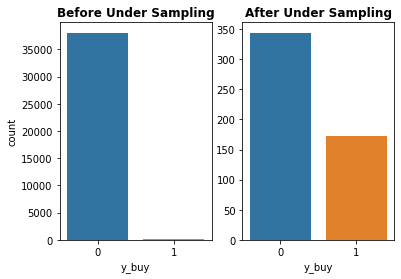

In [134]:
## Plot the figures:

ax = plt.subplot(gs[1]) # put this chart in 2nd place.
sns.countplot(x = "y_buy",data = Y_under, ax=ax) 
ax.set_title('After Under Sampling', fontsize=12, fontweight='bold')

ax2 = plt.subplot(gs[0])
sns.countplot(x = "y_buy", data = train, ax = ax2)
ax2.set_title('Before Under Sampling', fontsize=12, fontweight='bold') 

plt.show()

In [135]:
## Randomly split the training and test:

X_train, X_test, y_train, y_test = train_test_split(X_under, Y_under, test_size=0.25, random_state=12345)

In [136]:
print("the shape of X_train: " + str(X_train.shape))
print("the shape of Y_train: " + str(y_train.shape))
print("the shape of x_test: " + str(X_test.shape))
print("the shape of y_test: " + str(y_test.shape))

the shape of X_train: (387, 13)
the shape of Y_train: (387, 1)
the shape of x_test: (129, 13)
the shape of y_test: (129, 1)


#### 1. OLS Model

In [ ]:
linear = sm.OLS(y_train, X_train).fit()
print (linear.summary())

                                 OLS Regression Results                                
Dep. Variable:                  y_buy   R-squared (uncentered):                   0.544
Model:                            OLS   Adj. R-squared (uncentered):              0.529
Method:                 Least Squares   F-statistic:                              37.21
Date:                Thu, 03 Jun 2021   Prob (F-statistic):                    1.41e-56
Time:                        21:16:09   Log-Likelihood:                         -175.59
No. Observations:                 387   AIC:                                      375.2
Df Residuals:                     375   BIC:                                      422.7
Df Model:                          12                                                  
Covariance Type:            nonrobust                                                  
                          coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------

In [ ]:
## Backward Selection for variables:
X_train_trim = X_train.drop(['buy_freq','visit_freq','buy_interval','expected_time_buy','last_buy','multiple_buy','uniq_urls','num_checkins'], axis = 1)
linear2 = sm.OLS(y_train, X_train_trim).fit()
print(linear2.summary())

                                 OLS Regression Results                                
Dep. Variable:                  y_buy   R-squared (uncentered):                   0.532
Model:                            OLS   Adj. R-squared (uncentered):              0.528
Method:                 Least Squares   F-statistic:                              109.0
Date:                Thu, 03 Jun 2021   Prob (F-statistic):                    6.25e-62
Time:                        21:16:09   Log-Likelihood:                         -180.25
No. Observations:                 387   AIC:                                      368.5
Df Residuals:                     383   BIC:                                      384.3
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
                          coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:3889: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


In [ ]:
## Drop the variables for X_test also:
X_test_trim = X_test.drop(['buy_freq','visit_freq','buy_interval','expected_time_buy',\
                             'last_buy','multiple_buy','uniq_urls','num_checkins'], axis = 1)

#Set the threshold as 0.5:
y_pred_OLS = linear2.predict(X_test_trim)
y_pred_OLS = [ 0 if x < 0.5 else 1 for x in y_pred_OLS]

print(metrics.confusion_matrix(y_test, y_pred_OLS))
print ("Accuracy: " + str( metrics.accuracy_score(y_test, y_pred_OLS)*100)+" %")
print ("Precision: "+ str( metrics.precision_score(y_test, y_pred_OLS)*100) + " %")
print ( "Recall: "+ str( metrics.recall_score(y_test, y_pred_OLS)*100) +" %")


[[73  7]
 [23 26]]
Accuracy: 76.74418604651163 %
Precision: 78.78787878787878 %
Recall: 53.06122448979592 %


/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:3889: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


#### 2. Logit Model:

In [ ]:
X_train

,isbuyer,buy_freq,visit_freq,buy_interval,sv_interval,expected_time_buy,expected_time_visit,last_buy,multiple_buy,multiple_visit,uniq_urls,num_checkins
229,1.0,1.0,11.0,0.0,3.108333,0.0,-1.110363,3.0,0.0,1.0,27.0,106.0
500,0.0,0.0,2.0,0.0,12.125000,0.0,4.331263,1.0,0.0,1.0,18.0,85.0
272,0.0,0.0,1.0,0.0,0.000000,0.0,0.000000,30.0,0.0,0.0,22.0,596.0
295,0.0,0.0,1.0,0.0,0.000000,0.0,0.000000,44.0,0.0,0.0,170.0,1469.0
84,0.0,0.0,2.0,0.0,3.166667,0.0,-11.565050,13.0,0.0,1.0,81.0,1107.0
...,...,...,...,...,...,...,...,...,...,...,...,...
420,1.0,1.0,3.0,0.0,4.666667,0.0,-3.695151,6.0,0.0,1.0,8.0,27.0
129,0.0,0.0,2.0,0.0,19.375000,0.0,-95.423490,105.0,0.0,1.0,181.0,1148.0
285,0.0,0.0,1.0,0.0,0.000000,0.0,0.000000,24.0,0.0,0.0,117.0,562.0
485,1.0,1.0,3.0,0.0,0.625000,0.0,-1.506217,1.0,0.0,1.0,134.0,531.0


In [ ]:
def calc_vif(X):

    # Calculating VIF
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    return(vif)

In [ ]:
## Check VIF for Multicolinearity:
calc_vif(X_train)

In [115]:
## Drop multiple_buy due to high multicolinearity with multiple_visit
X_train_trim2 = X_train.drop(['multiple_buy','multiple_visit'], axis = 1)
X_test_trim2 = X_test.drop(['multiple_buy','multiple_visit' ], axis = 1)
#calc_vif(X_train_trim2)

AttributeError: ignored

In [139]:
X_train

,isbuyer,buy_freq,visit_freq,buy_interval,sv_interval,expected_time_buy,expected_time_visit,last_buy,last_visit,multiple_buy,multiple_visit,uniq_urls,num_checkins
229,1.0,2.0,28.0,2.5,1.773148,-32.36449,0.636996,1.0,1.0,1.0,1.0,18.0,167.0
500,0.0,0.0,2.0,0.0,12.125000,0.00000,4.331263,1.0,1.0,0.0,1.0,18.0,85.0
272,0.0,0.0,2.0,0.0,4.458333,0.00000,-93.340600,95.0,95.0,0.0,1.0,187.0,1009.0
295,0.0,0.0,1.0,0.0,0.000000,0.00000,0.000000,143.0,143.0,0.0,0.0,136.0,1743.0
84,0.0,0.0,1.0,0.0,0.000000,0.00000,0.000000,11.0,11.0,0.0,0.0,152.0,1115.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
420,1.0,1.0,3.0,0.0,4.666667,0.00000,-3.695151,6.0,6.0,0.0,1.0,8.0,27.0
129,0.0,0.0,1.0,0.0,0.000000,0.00000,0.000000,0.0,0.0,0.0,0.0,-1.0,1914.0
285,0.0,0.0,1.0,0.0,0.000000,0.00000,0.000000,126.0,126.0,0.0,0.0,188.0,1089.0
485,1.0,1.0,3.0,0.0,0.625000,0.00000,-1.506217,1.0,1.0,0.0,1.0,134.0,531.0


In [144]:
### Testing:: ##: 
X_train_logit = X_train[['visit_freq','expected_time_visit','last_visit','isbuyer']]
X_test_logit = X_test[['visit_freq','expected_time_visit','last_visit','isbuyer']]

X_train_logit['Intercept'] = 1
X_test_logit['Intercept'] = 1

## Build the Logit Model again with significant variables:
logit2 = sm.Logit(y_train, X_train_logit).fit()
print(logit2.summary())

Optimization terminated successfully.
         Current function value: 0.441830
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                  y_buy   No. Observations:                  387
Model:                          Logit   Df Residuals:                      382
Method:                           MLE   Df Model:                            4
Date:                Thu, 03 Jun 2021   Pseudo R-squ.:                  0.2933
Time:                        21:46:18   Log-Likelihood:                -170.99
converged:                       True   LL-Null:                       -241.96
Covariance Type:            nonrobust   LLR p-value:                 1.082e-29
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
visit_freq              0.0861      0.032      2.718      0.007       0.024       0.148
ex

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [147]:
logit2.summary2().tables[0].to_csv("/content/drive/My Drive/Boardroom_Group_5/Log_Minh_Logit_Update_1.csv")
logit2.summary2().tables[1].to_csv("/content/drive/My Drive/Boardroom_Group_5/Log_Minh_Logit_Update_2.csv")

In [111]:
## Drop the insignificant variable and keep only those significant:
X_train_logit = X_train_trim2[['visit_freq','expected_time_visit','last_buy','uniq_urls']]
X_test_logit = X_test_trim2[['visit_freq','expected_time_visit','last_buy','uniq_urls']]

## Build the Logit Model again with significant variables:
logit2 = sm.Logit(y_train, X_train_logit).fit()
print(logit2.summary())

Optimization terminated successfully.
         Current function value: 0.482161
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                  y_buy   No. Observations:                  387
Model:                          Logit   Df Residuals:                      383
Method:                           MLE   Df Model:                            3
Date:                Thu, 03 Jun 2021   Pseudo R-squ.:                  0.2288
Time:                        21:37:58   Log-Likelihood:                -186.60
converged:                       True   LL-Null:                       -241.96
Covariance Type:            nonrobust   LLR p-value:                 7.643e-24
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
visit_freq              0.1825      0.040      4.559      0.000       0.104       0.261
ex

In [104]:
## Fit into the test set:
y_pred_logit = logit2.predict(X_test_logit)
y_pred_logit = [ 0 if x < 0.5 else 1 for x in y_pred_logit]
print(metrics.confusion_matrix(y_test, y_pred_logit))
print ("Accuracy: " + str( metrics.accuracy_score(y_test, y_pred_logit)*100)+" %")
print ("Precision: "+ str( metrics.precision_score(y_test, y_pred_logit)*100) + " %")
print ( "Recall: "+ str( metrics.recall_score(y_test, y_pred_logit)*100) +" %")

ValueError: ignored

#### 3. Neutral Network

In [ ]:
## Normalize the data first:
scaler = StandardScaler()  
scaler.fit(X_train)
X_train = scaler.transform(X_train)  
X_test = scaler.transform(X_test) 


In [ ]:
## Multi-layer perceptron classification - one hidden layer of 3 neurons
mlp = MLPClassifier(hidden_layer_sizes=(3), max_iter=1000)  
mlp.fit(X_train, y_train)  

  
## predict test set 
y_pred_NN = mlp.predict(X_test)  

## confusion matrix
print(metrics.confusion_matrix(y_test, y_pred_NN)) 
print ("Accuracy: " + str( metrics.accuracy_score(y_test, y_pred_NN)*100)+" %")
print ("Precision: "+ str( metrics.precision_score(y_test, y_pred_NN)*100) + " %")
print ( "Recall: "+ str( metrics.recall_score(y_test, y_pred_NN)*100) +" %")


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:934: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[[70 10]
 [19 30]]
Accuracy: 77.51937984496125 %
Precision: 75.0 %
Recall: 61.224489795918366 %


After trimming techniques, it seem like the best one is Activation = Logistic and Hidden_layer = 6. This one yeild the highest combination of Accuracy and Preceision. To be more specific, this one have the highest Recall rate, which is the model sensitivity. 
The one with Activation = Identity and Hidden_layer = 4 have the highest Precision, yet the Recall is nocticeably lower than this one. So I choose this one. 


In [ ]:
# Build the NN model again with such trimmed features:
## Multi-layer perceptron classification - one hidden layer of 4 neurons, activition = Identity
mlp2 = MLPClassifier(hidden_layer_sizes=(6), max_iter=1000,random_state = 109, activation = 'logistic')  
mlp2.fit(X_train, y_train)  

  
## predict test set 
y_pred_NN_2 = mlp2.predict(X_test)  

## confusion matrix
print(metrics.confusion_matrix(y_test, y_pred_NN_2)) 
print ("Accuracy: " + str( metrics.accuracy_score(y_test, y_pred_NN_2)*100)+" %")
print ("Precision: "+ str( metrics.precision_score(y_test, y_pred_NN_2)*100) + " %")
print ( "Recall: "+ str( metrics.recall_score(y_test, y_pred_NN_2)*100) +" %")

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:934: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[[74  6]
 [19 30]]
Accuracy: 80.62015503875969 %
Precision: 83.33333333333334 %
Recall: 61.224489795918366 %


### 4. Logit with Intercept:


In [105]:
X_train['Intercept'] = 1
X_test['Intercept'] = 1


IndexError: ignored

In [106]:
y_train['y_buy'] = y_train['y_buy'].astype('category').cat.codes

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
logit2 = sm.Logit(y_train,X_train).fit()

Optimization terminated successfully.
         Current function value: 0.412400
         Iterations 11


In [ ]:
print(logit2.summary())

                           Logit Regression Results                           
Dep. Variable:                  y_buy   No. Observations:                  387
Model:                          Logit   Df Residuals:                      374
Method:                           MLE   Df Model:                           12
Date:                Wed, 02 Jun 2021   Pseudo R-squ.:                  0.3149
Time:                        17:36:16   Log-Likelihood:                -165.77
converged:                       True   LL-Null:                       -241.96
Covariance Type:            nonrobust   LLR p-value:                 1.858e-26
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
isbuyer                 2.2691      0.595      3.816      0.000       1.104       3.435
buy_freq               -0.5674      0.310     -1.831      0.067      -1.175       0.040
visit_freq      

In [ ]:
## Drop the insignificant variables:
X_train_logit2 = X_train[['isbuyer','visit_freq','last_buy','multiple_visit','uniq_urls','Intercept']]
X_test_logit2 = X_test[['isbuyer','visit_freq','last_buy','multiple_visit','uniq_urls','Intercept']]

In [ ]:
## Build the model with significant variables:
logit3 = sm.Logit(y_train, X_train_logit2).fit()
print(logit3.summary())

Optimization terminated successfully.
         Current function value: 0.439066
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                  y_buy   No. Observations:                  387
Model:                          Logit   Df Residuals:                      381
Method:                           MLE   Df Model:                            5
Date:                Wed, 02 Jun 2021   Pseudo R-squ.:                  0.2977
Time:                        17:44:16   Log-Likelihood:                -169.92
converged:                       True   LL-Null:                       -241.96
Covariance Type:            nonrobust   LLR p-value:                 2.422e-29
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
isbuyer            1.6611      0.422      3.932      0.000       0.833       2.489
visit_freq       

In [ ]:
#Confusion Matrix:
y_pred_logit = logit3.predict(X_test_logit2)
y_pred_logit = [ 0 if x < 0.5 else 1 for x in y_pred_logit]
print(metrics.confusion_matrix(y_test, y_pred_logit))
print ("Accuracy: " + str( metrics.accuracy_score(y_test, y_pred_logit)*100)+" %")
print ("Precision: "+ str( metrics.precision_score(y_test, y_pred_logit)*100) + " %")
print ( "Recall: "+ str( metrics.recall_score(y_test, y_pred_logit)*100) +" %")

[[73  7]
 [24 25]]
Accuracy: 75.96899224806202 %
Precision: 78.125 %
Recall: 51.02040816326531 %


In [ ]:
X_train_trim2['Intercept'] = 1
X_test_trim2['Intercept'] = 1

In [ ]:
y_train['y_buy'] = y_train['y_buy'].astype('category').cat.codes

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
X_train.drop(['Buyer_ID'], axis = 1, inplace = True)
X_test.drop(['Buyer_ID'], axis = 1, inplace = True)

In [ ]:
X_train_trim2 = X_train.drop(['multiple_buy','multiple_visit'], axis = 1)
X_test_trim2 = X_test.drop(['multiple_buy','multiple_visit' ], axis = 1)

KeyError: ignored

In [ ]:
logit = sm.Logit(y_train, X_train_trim2).fit()
print(logit.summary())

         Current function value: inf
         Iterations: 35


/usr/local/lib/python3.7/dist-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/usr/local/lib/python3.7/dist-packages/statsmodels/discrete/discrete_model.py:1789: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


LinAlgError: ignored